# Midterm Project
>For images provided in the attached file (data01.zip), make a partition to form a training set, a validation set, and a test set. Use at least two approaches (or networks) to classify the images into two categories (One indicates that the ground is empty and the other indicates that the ground has something on it). Try different hyper-parameters on the two approaches, demonstrate how well your algorithms are in terms of recall, precision, and F1 score, and make some comments according to your own understanding about the results. Write in .ipynb file with necessary markdown documentation. You are required to do it by yourself only, which means that no two hand-in solutions shall have exactly the same two approaches.  

12232509 Fan Qingyuan

As the images in the dataset has differnt channel and size, we firstly apply a normalization to make them have the same size and channel and save them into png (in `normalize-dataset.ipynb`). Then we use the following two approaches to classify the images into two categories.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import copy
torch.manual_seed(88010123)
print("Current torch seed: ", torch.initial_seed())
from torchinfo import summary

Current torch seed:  88010123


## Define the dataset class and the dataloader class

Then, we need to define the dataset class and the dataloader class. As the number of the two classes in the dataset is not balanced, we need to do data augmentation and generate new samples by applying transformations such as rotation, scaling and flipping on the existing minority class images. This helps increase the diversity of the minority class without losing important information.

In [2]:
import random
from torch.utils.data import Dataset, random_split
from torchvision.io import read_image
from pathlib import Path


class CustomDataset(Dataset):
    def __init__(
        self,
        img_dir,
        transform=None,
        train=True,
        augment_minority=True,
        minority_multiplier=int(2000 / 460),
    ):
        self.img_dir = Path(img_dir)
        self.transform = transform
        self.train = train
        self.augment_minority = augment_minority
        self.minority_multiplier = minority_multiplier

        self.empty_imgs = list((self.img_dir / "empty").glob("*.png"))
        self.occupied_imgs = list((self.img_dir / "occupied").glob("*.png"))

        # balance datasets using augmentation
        if self.augment_minority and self.train:
            self.empty_imgs = (
                self.empty_imgs * self.minority_multiplier
                + random.sample(self.empty_imgs, 160)
            )

        self.all_imgs = self.empty_imgs + self.occupied_imgs
        random.shuffle(self.all_imgs)

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        img_path = self.all_imgs[idx]
        img = read_image(str(img_path)).float() / 255.0

        label = 0 if "empty" in img_path.parts else 1

        if self.transform:
            img = self.transform(img)

        # if self.augment_minority and self.train and label == 0:
        #     img = self.minority_augmentation(img)

        return img, label

    # add a func to return the file name
    def get_file_name(self, idx):
        img_path = self.all_imgs[idx]
        return img_path.parts[-1]


# Apply transformations, resize it to 224x224

data_transforms = {
    "train": transforms.Compose(
        [               
            transforms.RandomRotation(degrees=(0, 180)),
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
}


# Load the dataset
We load the datset and split it into training (80%), validation (10%), and testing (10%) sets. Ensure that the split is stratified so that the distribution of the two categories is maintained in all the sets.

In [3]:
# Create custom dataset
full_dataset = CustomDataset(
    "/home/fanqy/research-temp/eee5015/mid-proj/normalized_datasets"
)
print("Number of empty images:", len(full_dataset.empty_imgs))
print("Number of occupied images:", len(full_dataset.occupied_imgs))
print("Total images:", len(full_dataset))

# Calculate the lengths of the train, validation, and test sets
train_len = int(0.8 * len(full_dataset))
val_len = int(0.1 * len(full_dataset))
test_len = len(full_dataset) - train_len - val_len

# Split the dataset
train_set, val_set, test_set = random_split(
    full_dataset, [train_len, val_len, test_len]
)

# apply transformations
train_set = copy.deepcopy(train_set)
train_set.dataset.transform = data_transforms["train"]
val_set = copy.deepcopy(val_set)
val_set.dataset.transform = data_transforms["val"]
test_set = copy.deepcopy(test_set)
test_set.dataset.transform = data_transforms["val"]


# Create data loaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=4)

# Update data loaders and dataset sizes
dataloaders = {"train": train_loader, "val": val_loader}
dataset_sizes = {"train": train_len, "val": val_len}
class_names = ["empty", "occupied"]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Number of empty images: 2000
Number of occupied images: 2000
Total images: 4000


### Plot some figures from the dataset to verify the transformation

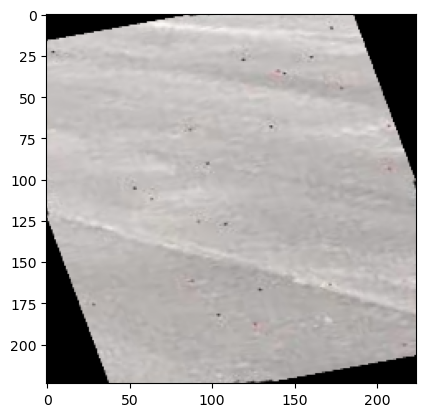

In [4]:
# plot some fig from train set
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

imshow(train_set[1][0])


## Construct the network

before we construct the network, we need to define the function to train the network and the function to evaluate the network.

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    train_acc_lst, valid_acc_lst = [], []
    train_loss_lst, valid_loss_lst = [], []
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                # print(inputs.shape)
                # print(labels.shape)
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # update learning rate
            if phase == "train":
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # print current epoch loss and accuracy
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            train_acc_lst.append(epoch_acc) if phase == "train" else valid_acc_lst.append(epoch_acc)
            train_loss_lst.append(epoch_loss) if phase == "train" else valid_loss_lst.append(epoch_loss)

            # deep copy the model to save the best model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model)

    return model, best_model_wts, train_acc_lst, valid_acc_lst, train_loss_lst, valid_loss_lst


In [6]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def verify_model(model, test_loader):
    model.eval()

    correct = 0
    total = 0

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions, average="weighted")
    precision = precision_score(all_labels, all_predictions, average="weighted")
    f1 = f1_score(all_labels, all_predictions, average="weighted")

    print("Accuracy: {:.2f}%".format(accuracy * 100))
    print("Recall: {:.2f}%".format(recall * 100))
    print("Precision: {:.2f}%".format(precision * 100))
    print("F1 Score: {:.2f}%".format(f1 * 100))


### Pretrained ResNet50

In the first approach, we use a pretrained ResNet50 model and fine-tune it on our dataset. We use the `torchvision.models.resnet50` module to load the pretrained model. We then replace the final layer with a new fully connected layer with two outputs. We also freeze the weights of the pretrained model so that only the weights of the final layer are updated during training.

In [15]:
# load and modify resnet pretrained model, and only output two classes
resnet18_pretrained = models.resnet18(weights=True)
resnet18_pretrained.fc = nn.Linear(512, 2)
# freeze all layers except the last fc layer
for param in resnet18_pretrained.parameters():
    param.requires_grad = False
for param in resnet18_pretrained.fc.parameters():
    param.requires_grad = True
resnet18_pretrained.to(device)
summary(resnet18_pretrained, input_size=(64, 3, 224, 224))

/home/fanqy/mambaforge/envs/eee5015-py39-torchgpu/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 2]                   --
├─Conv2d: 1-1                            [64, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [64, 64, 112, 112]        (128)
├─ReLU: 1-3                              [64, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [64, 64, 56, 56]          --
├─Sequential: 1-5                        [64, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [64, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [64, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-2             [64, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [64, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [64, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [64, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [64, 64, 56, 56]  

#### with SGD optimizer

In [11]:
# using SGD optimizer
criterion = nn.CrossEntropyLoss()
optimizer_resnet18_sgd = optim.SGD(
    resnet18_pretrained.parameters(), lr=0.01, momentum=0.9
)
optimizer_resnet18_adam = torch.optim.Adam(resnet18_pretrained.parameters(), lr=1e-4)
exp_lr_scheduler_resnet18 = lr_scheduler.StepLR(
    optimizer_resnet18_sgd, step_size=7, gamma=0.1
)
# train
(
    model_resnet18,
    best_model_resnet18,
    train_acc_lst,
    valid_acc_lst,
    train_loss_lst,
    valid_loss_lst,
) = train_model(
    resnet18_pretrained,
    criterion,
    optimizer_resnet18_sgd,
    exp_lr_scheduler_resnet18,
    num_epochs=30,
)
# detatch the train_acc_lst, valid_acc_lst, train_loss_lst, valid_loss_lst
train_acc_lst = [i.detach().cpu().numpy() for i in train_acc_lst]
valid_acc_lst = [i.detach().cpu().numpy() for i in valid_acc_lst]


Epoch 0/29
train Loss: 0.1973 Acc: 0.9234
val Loss: 0.1878 Acc: 0.9275
Epoch 1/29
train Loss: 0.0946 Acc: 0.9688
val Loss: 0.0774 Acc: 0.9750
Epoch 2/29
train Loss: 0.0828 Acc: 0.9675
val Loss: 0.1248 Acc: 0.9600
Epoch 3/29
train Loss: 0.0683 Acc: 0.9747
val Loss: 0.1057 Acc: 0.9675
Epoch 4/29
train Loss: 0.0788 Acc: 0.9697
val Loss: 0.0578 Acc: 0.9850
Epoch 5/29
train Loss: 0.0748 Acc: 0.9719
val Loss: 0.0573 Acc: 0.9825
Epoch 6/29
train Loss: 0.0602 Acc: 0.9781
val Loss: 0.0481 Acc: 0.9875
Epoch 7/29
train Loss: 0.0546 Acc: 0.9791
val Loss: 0.0495 Acc: 0.9875
Epoch 8/29
train Loss: 0.0641 Acc: 0.9772
val Loss: 0.0495 Acc: 0.9900
Epoch 9/29
train Loss: 0.0561 Acc: 0.9794
val Loss: 0.0549 Acc: 0.9850
Epoch 10/29
train Loss: 0.0613 Acc: 0.9769
val Loss: 0.0636 Acc: 0.9800
Epoch 11/29
train Loss: 0.0604 Acc: 0.9756
val Loss: 0.0501 Acc: 0.9875
Epoch 12/29
train Loss: 0.0543 Acc: 0.9809
val Loss: 0.0547 Acc: 0.9850
Epoch 13/29
train Loss: 0.0543 Acc: 0.9816
val Loss: 0.0506 Acc: 0.9875
Ep

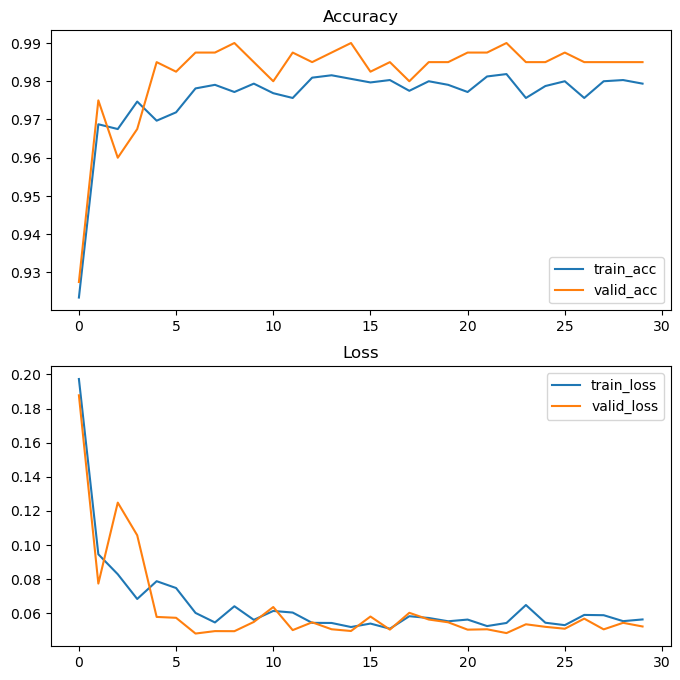

Accuracy: 99.50%
Recall: 99.50%
Precision: 99.51%
F1 Score: 99.50%


In [12]:
# plot the accuracy and loss, then verify the model using test set
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
axs[0].plot(train_acc_lst, label='train_acc')
axs[0].plot(valid_acc_lst, label='valid_acc')
axs[0].set_title('Accuracy')
axs[0].legend()
axs[1].plot(train_loss_lst, label='train_loss')
axs[1].plot(valid_loss_lst, label='valid_loss')
axs[1].set_title('Loss')
axs[1].legend()
plt.show()
verify_model(best_model_resnet18, test_loader)

#### with Adam optimizer

In [16]:
# using adam optimizer
criterion = nn.CrossEntropyLoss()
optimizer_resnet18_sgd = optim.SGD(
    resnet18_pretrained.parameters(), lr=0.01, momentum=0.9
)
optimizer_resnet18_adam = torch.optim.Adam(resnet18_pretrained.parameters(), lr=1e-4)
exp_lr_scheduler_resnet18 = lr_scheduler.StepLR(
    optimizer_resnet18_adam, step_size=7, gamma=0.1
)
# train
(
    model_resnet18,
    best_model_resnet18,
    train_acc_lst,
    valid_acc_lst,
    train_loss_lst,
    valid_loss_lst,
) = train_model(
    resnet18_pretrained,
    criterion,
    optimizer_resnet18_sgd,
    exp_lr_scheduler_resnet18,
    num_epochs=30,
)
# detatch the train_acc_lst, valid_acc_lst, train_loss_lst, valid_loss_lst
train_acc_lst = [i.detach().cpu().numpy() for i in train_acc_lst]
valid_acc_lst = [i.detach().cpu().numpy() for i in valid_acc_lst]


Epoch 0/29
train Loss: 0.1575 Acc: 0.9247


/home/fanqy/mambaforge/envs/eee5015-py39-torchgpu/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


val Loss: 0.0877 Acc: 0.9675
Epoch 1/29
train Loss: 0.0970 Acc: 0.9634
val Loss: 0.0795 Acc: 0.9700
Epoch 2/29
train Loss: 0.0853 Acc: 0.9669
val Loss: 0.0749 Acc: 0.9750
Epoch 3/29
train Loss: 0.1011 Acc: 0.9628
val Loss: 0.0695 Acc: 0.9775
Epoch 4/29
train Loss: 0.0730 Acc: 0.9706
val Loss: 0.0714 Acc: 0.9775
Epoch 5/29
train Loss: 0.0752 Acc: 0.9719
val Loss: 0.0643 Acc: 0.9775
Epoch 6/29
train Loss: 0.0832 Acc: 0.9716
val Loss: 0.0551 Acc: 0.9800
Epoch 7/29
train Loss: 0.0577 Acc: 0.9803
val Loss: 0.0555 Acc: 0.9850
Epoch 8/29
train Loss: 0.0859 Acc: 0.9653
val Loss: 0.0512 Acc: 0.9850
Epoch 9/29
train Loss: 0.0719 Acc: 0.9759
val Loss: 0.0545 Acc: 0.9825
Epoch 10/29
train Loss: 0.0654 Acc: 0.9778
val Loss: 0.0512 Acc: 0.9850
Epoch 11/29
train Loss: 0.0603 Acc: 0.9747
val Loss: 0.0732 Acc: 0.9775
Epoch 12/29
train Loss: 0.0660 Acc: 0.9731
val Loss: 0.0502 Acc: 0.9825
Epoch 13/29
train Loss: 0.0603 Acc: 0.9756
val Loss: 0.0721 Acc: 0.9725
Epoch 14/29
train Loss: 0.0517 Acc: 0.9822
v

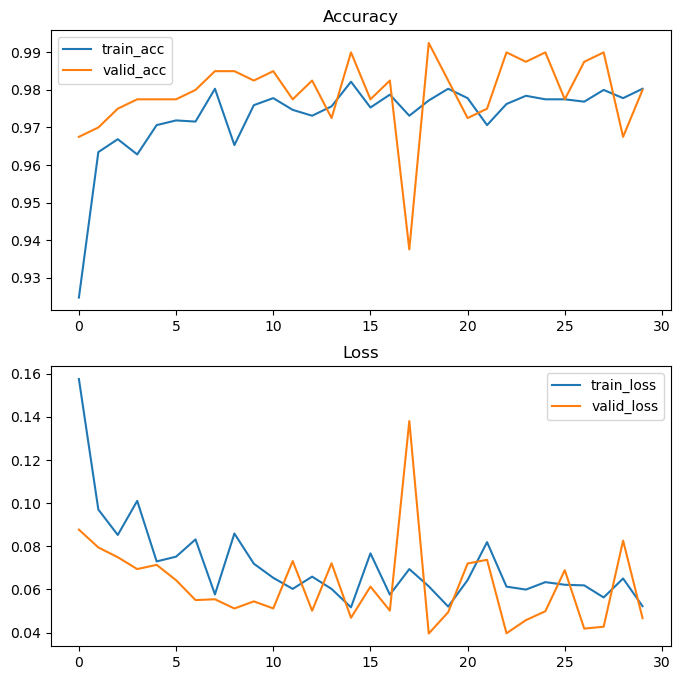

Accuracy: 99.00%
Recall: 99.00%
Precision: 99.02%
F1 Score: 99.00%


In [18]:
# plot the accuracy and loss, then verify the model using test set
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
axs[0].plot(train_acc_lst, label='train_acc')
axs[0].plot(valid_acc_lst, label='valid_acc')
axs[0].set_title('Accuracy')
axs[0].legend()
axs[1].plot(train_loss_lst, label='train_loss')
axs[1].plot(valid_loss_lst, label='valid_loss')
axs[1].set_title('Loss')
axs[1].legend()
plt.show()
verify_model(best_model_resnet18, test_loader)

### Custom CNN without attention (pure CNN)

In the second approach, we use a pure CNN model, designed without any attention mechanism, to explore its performance in comparison to models with attention.

The architecture begins with three convolutional layers (`conv1`, `conv2`, and `conv3`) with increasing output channels from 32 to 128. Each convolutional layer uses a kernel size of 3 and padding of 1. These layers are responsible for learning the local spatial features within the input images. The `pool` operation, which is a max pooling layer with kernel size 2 and stride 2, is applied after each convolutional layer to reduce the spatial dimensions and minimize computational requirements.

The `avgpool` layer, an adaptive average pooling operation, is applied to the output of the third convolutional layer to further downsample the feature maps to a fixed size of 16x16. This allows the model to adapt to various input sizes and maintain a consistent output shape for the fully connected layers that follow.

The fully connected layers (`fc1` and `fc2`) are responsible for learning higher-level features from the feature maps and mapping them to the final output classes. A dropout layer with a probability of 0.5 is applied between these two layers to mitigate overfitting. The output of the model is produced by applying a softmax activation function along dimension 1, resulting in probability distributions over the two output classes.

In [19]:
# my custom model w/o attention

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = F.relu(x)
        return x

class CustomCNNWithoutAttention(nn.Module):
    def __init__(self):
        super(CustomCNNWithoutAttention, self).__init__()

        self.conv_block1 = nn.Sequential(
            ConvBlock(3, 32),
            ConvBlock(32, 32),
            ConvBlock(32, 32),
        )
        self.conv_block2 = nn.Sequential(
            ConvBlock(32, 64),
            ConvBlock(64, 64),
            ConvBlock(64, 64),
        )
        self.conv_block3 = nn.Sequential(
            ConvBlock(64, 128),
            ConvBlock(128, 128),
            ConvBlock(128, 128),
        )

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 2)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.pool(x)

        x = self.conv_block2(x)
        x = self.pool(x)

        x = self.conv_block3(x)
        x = self.pool(x)

        x = x.view(-1, 128 * 28 * 28)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        output = F.softmax(x, dim=1)
        return output

CustomCNNWithoutAttention_model = CustomCNNWithoutAttention()
CustomCNNWithoutAttention_model = CustomCNNWithoutAttention_model.to(device)
print(CustomCNNWithoutAttention_model)
summary(CustomCNNWithoutAttention_model, input_size=(64, 3, 224, 224))


CustomCNNWithoutAttention(
  (conv_block1): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (conv_block2): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNor

Layer (type:depth-idx)                   Output Shape              Param #
CustomCNNWithoutAttention                [64, 2]                   --
├─Sequential: 1-1                        [64, 32, 224, 224]        --
│    └─ConvBlock: 2-1                    [64, 32, 224, 224]        --
│    │    └─Conv2d: 3-1                  [64, 32, 224, 224]        896
│    │    └─BatchNorm2d: 3-2             [64, 32, 224, 224]        64
│    └─ConvBlock: 2-2                    [64, 32, 224, 224]        --
│    │    └─Conv2d: 3-3                  [64, 32, 224, 224]        9,248
│    │    └─BatchNorm2d: 3-4             [64, 32, 224, 224]        64
│    └─ConvBlock: 2-3                    [64, 32, 224, 224]        --
│    │    └─Conv2d: 3-5                  [64, 32, 224, 224]        9,248
│    │    └─BatchNorm2d: 3-6             [64, 32, 224, 224]        64
├─MaxPool2d: 1-2                         [64, 32, 112, 112]        --
├─Sequential: 1-3                        [64, 64, 112, 112]        --
│    └─C

#### with SGD optimizer

In [20]:
# using sgd optimizer
criterion = nn.CrossEntropyLoss()
optimizer_CustomCNNWithoutAttention_model_sgd = optim.SGD(
    CustomCNNWithoutAttention_model.parameters(), lr=0.001, momentum=0.9
)
optimizer_CustomCNNWithoutAttention_model_adam = torch.optim.Adam(
    CustomCNNWithoutAttention_model.parameters(), lr=1e-4
)
exp_lr_scheduler_CustomCNNWithoutAttention = lr_scheduler.StepLR(
    optimizer_CustomCNNWithoutAttention_model_sgd, step_size=7, gamma=0.1
)
# train
(
    model_CustomCNNWithoutAttention,
    best_model_CustomCNNWithoutAttention,
    train_acc_lst,
    valid_acc_lst,
    train_loss_lst,
    valid_loss_lst,
) = train_model(
    CustomCNNWithoutAttention_model,
    criterion,
    optimizer_CustomCNNWithoutAttention_model_sgd,
    exp_lr_scheduler_CustomCNNWithoutAttention,
    num_epochs=30,
)
# detatch the train_acc_lst, valid_acc_lst, train_loss_lst, valid_loss_lst
train_acc_lst = [i.detach().cpu().numpy() for i in train_acc_lst]
valid_acc_lst = [i.detach().cpu().numpy() for i in valid_acc_lst]

Epoch 0/29
train Loss: 0.4242 Acc: 0.8888
val Loss: 0.4492 Acc: 0.8575
Epoch 1/29
train Loss: 0.3880 Acc: 0.9238
val Loss: 0.3861 Acc: 0.9250
Epoch 2/29
train Loss: 0.3827 Acc: 0.9300
val Loss: 0.3802 Acc: 0.9300
Epoch 3/29
train Loss: 0.3802 Acc: 0.9309
val Loss: 0.3823 Acc: 0.9250
Epoch 4/29
train Loss: 0.3728 Acc: 0.9375
val Loss: 0.3758 Acc: 0.9325
Epoch 5/29
train Loss: 0.3719 Acc: 0.9378
val Loss: 0.3709 Acc: 0.9500
Epoch 6/29
train Loss: 0.3614 Acc: 0.9494
val Loss: 0.3587 Acc: 0.9425
Epoch 7/29
train Loss: 0.3588 Acc: 0.9506
val Loss: 0.3529 Acc: 0.9550
Epoch 8/29
train Loss: 0.3567 Acc: 0.9563
val Loss: 0.3477 Acc: 0.9600
Epoch 9/29
train Loss: 0.3518 Acc: 0.9616
val Loss: 0.3468 Acc: 0.9675
Epoch 10/29
train Loss: 0.3516 Acc: 0.9616
val Loss: 0.3447 Acc: 0.9650
Epoch 11/29
train Loss: 0.3512 Acc: 0.9606
val Loss: 0.3449 Acc: 0.9750
Epoch 12/29
train Loss: 0.3498 Acc: 0.9597
val Loss: 0.3411 Acc: 0.9775
Epoch 13/29
train Loss: 0.3489 Acc: 0.9647
val Loss: 0.3441 Acc: 0.9750
Ep

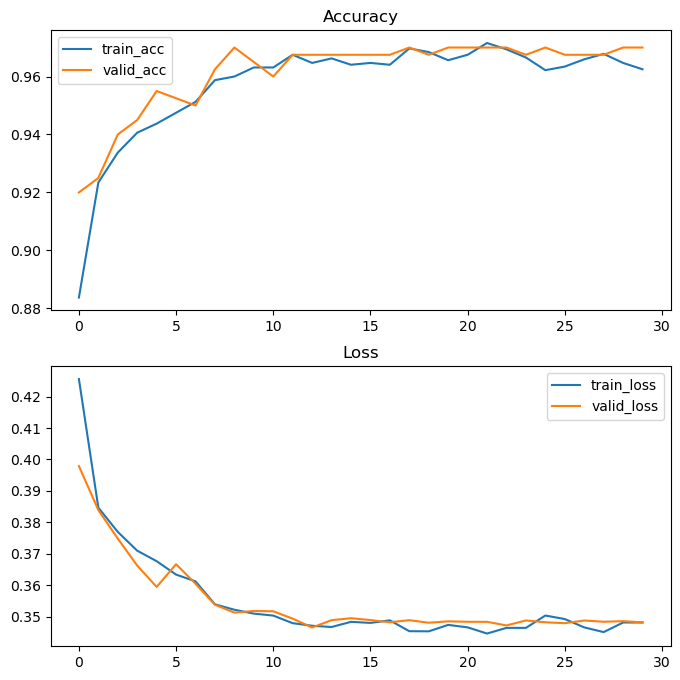

Accuracy: 95.75%
Recall: 95.75%
Precision: 96.08%
F1 Score: 95.74%


In [ ]:
# plot the accuracy and loss, then verify the model using test set
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
axs[0].plot(train_acc_lst, label='train_acc')
axs[0].plot(valid_acc_lst, label='valid_acc')
axs[0].set_title('Accuracy')
axs[0].legend()
axs[1].plot(train_loss_lst, label='train_loss')
axs[1].plot(valid_loss_lst, label='valid_loss')
axs[1].set_title('Loss')
axs[1].legend()
plt.show()
verify_model(best_model_CustomCNNWithoutAttention, test_loader)

#### with Adam optimizer

In [ ]:
# using adam optimizer
criterion = nn.CrossEntropyLoss()
optimizer_CustomCNNWithoutAttention_model_sgd = optim.SGD(
    CustomCNNWithoutAttention_model.parameters(), lr=0.01, momentum=0.9
)
optimizer_CustomCNNWithoutAttention_model_adam = torch.optim.Adam(
    CustomCNNWithoutAttention_model.parameters(), lr=1e-4
)
exp_lr_scheduler_CustomCNNWithoutAttention = lr_scheduler.StepLR(
    optimizer_CustomCNNWithoutAttention_model_adam, step_size=7, gamma=0.1
)
# train
(
    model_CustomCNNWithoutAttention,
    best_model_CustomCNNWithoutAttention,
    train_acc_lst,
    valid_acc_lst,
    train_loss_lst,
    valid_loss_lst,
) = train_model(
    CustomCNNWithoutAttention_model,
    criterion,
    optimizer_CustomCNNWithoutAttention_model_adam,
    exp_lr_scheduler_CustomCNNWithoutAttention,
    num_epochs=30,
)
# detatch the train_acc_lst, valid_acc_lst, train_loss_lst, valid_loss_lst
train_acc_lst = [i.detach().cpu().numpy() for i in train_acc_lst]
valid_acc_lst = [i.detach().cpu().numpy() for i in valid_acc_lst]

Epoch 0/29
train Loss: 0.4356 Acc: 0.8741
val Loss: 0.4100 Acc: 0.9025
Epoch 1/29
train Loss: 0.3915 Acc: 0.9200
val Loss: 0.3870 Acc: 0.9275
Epoch 2/29
train Loss: 0.3789 Acc: 0.9331
val Loss: 0.3752 Acc: 0.9400
Epoch 3/29
train Loss: 0.3704 Acc: 0.9431
val Loss: 0.3747 Acc: 0.9375
Epoch 4/29
train Loss: 0.3639 Acc: 0.9481
val Loss: 0.3659 Acc: 0.9475
Epoch 5/29
train Loss: 0.3675 Acc: 0.9459
val Loss: 0.3648 Acc: 0.9475
Epoch 6/29
train Loss: 0.3638 Acc: 0.9494
val Loss: 0.3593 Acc: 0.9525
Epoch 7/29
train Loss: 0.3524 Acc: 0.9597
val Loss: 0.3508 Acc: 0.9625
Epoch 8/29
train Loss: 0.3516 Acc: 0.9613
val Loss: 0.3519 Acc: 0.9625
Epoch 9/29
train Loss: 0.3501 Acc: 0.9622
val Loss: 0.3470 Acc: 0.9675
Epoch 10/29
train Loss: 0.3450 Acc: 0.9681
val Loss: 0.3418 Acc: 0.9725
Epoch 11/29
train Loss: 0.3442 Acc: 0.9675
val Loss: 0.3415 Acc: 0.9725
Epoch 12/29
train Loss: 0.3460 Acc: 0.9666
val Loss: 0.3422 Acc: 0.9700
Epoch 13/29
train Loss: 0.3432 Acc: 0.9706
val Loss: 0.3418 Acc: 0.9725
Ep

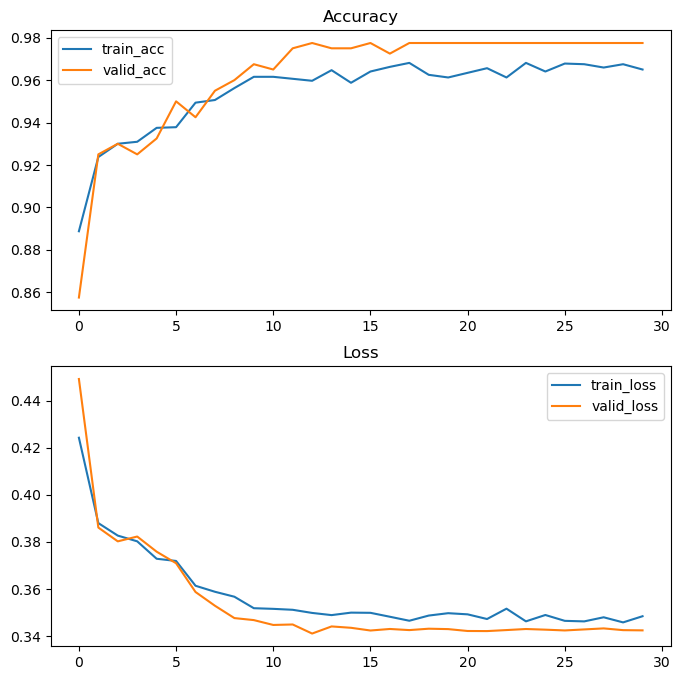

Accuracy: 96.75%
Recall: 96.75%
Precision: 96.76%
F1 Score: 96.75%


In [21]:
# plot the accuracy and loss, then verify the model using test set
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
axs[0].plot(train_acc_lst, label='train_acc')
axs[0].plot(valid_acc_lst, label='valid_acc')
axs[0].set_title('Accuracy')
axs[0].legend()
axs[1].plot(train_loss_lst, label='train_loss')
axs[1].plot(valid_loss_lst, label='valid_loss')
axs[1].set_title('Loss')
axs[1].legend()
plt.show()
verify_model(best_model_CustomCNNWithoutAttention, test_loader)

### Custom CNN Model with attention
To improve the prediction accuracy of the model, we added attention to this network, resulting in a new architecture called CustomCNNWithAttention. The purpose of the attention layer is to enhance the model's ability to focus on relevant spatial features within the input images.

The self-attention mechanism is implemented using the `SelfAttention` class, which comprises three convolutional layers: query, key, and value. These layers are responsible for generating query, key, and value matrices from the input feature maps. The attention weights are calculated by taking the dot product between the query and key matrices, followed by a softmax activation function to normalize the weights.

The output of the attention layer is generated by multiplying the value matrix with the transposed attention weights and reshaping the result back to the original feature map dimensions. A learnable gamma parameter is introduced to control the extent to which the self-attention mechanism contributes to the final output. The input feature maps and the attention output are combined through a residual connection.

The CustomCNNWithAttention architecture follows the same structure as the CustomCNNWithoutAttention model, with the addition of the self-attention layer after the adaptive average pooling (avgpool) operation. The remaining layers, including the fully connected layers, dropout, and softmax activation, are unchanged.

In [ ]:
# my custom model, with attention

class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()

        self.query = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)

        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, width, height = x.size()

        query = self.query(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        key = self.key(x).view(batch_size, -1, width * height)
        value = self.value(x).view(batch_size, -1, width * height)

        attention = torch.bmm(query, key)
        attention = F.softmax(attention, dim=-1)
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)

        return self.gamma * out + x
    
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = F.relu(x)
        return x

class CustomCNNWithAttention(nn.Module):
    def __init__(self):
        super(CustomCNNWithAttention, self).__init__()

        self.conv_block1 = nn.Sequential(
            ConvBlock(3, 32),
            ConvBlock(32, 32),
            ConvBlock(32, 32),
        )
        self.conv_block2 = nn.Sequential(
            ConvBlock(32, 64),
            ConvBlock(64, 64),
            ConvBlock(64, 64),
        )
        self.conv_block3 = nn.Sequential(
            ConvBlock(64, 128),
            ConvBlock(128, 128),
            ConvBlock(128, 128),
        )
        self.conv_block4 = nn.Sequential(
            ConvBlock(128, 256),
            ConvBlock(256, 256),
            ConvBlock(256, 256),
        )

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.attention1 = SelfAttention(in_channels=128)

        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 2)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.pool(x)

        x = self.conv_block2(x)
        x = self.pool(x)

        x = self.conv_block3(x)
        x = self.pool(x)

        x = self.attention1(x)

        x = x.view(-1, 128 * 28 * 28)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        output = F.softmax(x, dim=1)
        return output
    

CustomCNNWithAttention_model = CustomCNNWithAttention().to(device)
print(CustomCNNWithAttention_model)
summary(CustomCNNWithAttention_model, input_size=(64, 3, 224, 224))


CustomCNNWithAttention(
  (conv_block1): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (conv_block2): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d

Layer (type:depth-idx)                   Output Shape              Param #
CustomCNNWithAttention                   [64, 2]                   1,476,864
├─Sequential: 1-1                        [64, 32, 224, 224]        --
│    └─ConvBlock: 2-1                    [64, 32, 224, 224]        --
│    │    └─Conv2d: 3-1                  [64, 32, 224, 224]        896
│    │    └─BatchNorm2d: 3-2             [64, 32, 224, 224]        64
│    └─ConvBlock: 2-2                    [64, 32, 224, 224]        --
│    │    └─Conv2d: 3-3                  [64, 32, 224, 224]        9,248
│    │    └─BatchNorm2d: 3-4             [64, 32, 224, 224]        64
│    └─ConvBlock: 2-3                    [64, 32, 224, 224]        --
│    │    └─Conv2d: 3-5                  [64, 32, 224, 224]        9,248
│    │    └─BatchNorm2d: 3-6             [64, 32, 224, 224]        64
├─MaxPool2d: 1-2                         [64, 32, 112, 112]        --
├─Sequential: 1-3                        [64, 64, 112, 112]        --
│

#### with SGD optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_CustomCNNWithAttention_model_sgd = optim.SGD(
    CustomCNNWithAttention_model.parameters(), lr=0.001, momentum=0.9
)
optimizer_CustomCNNWithAttention_model_adam = torch.optim.Adam(
    CustomCNNWithAttention_model.parameters(), lr=1e-4
)
exp_lr_scheduler_CustomCNNWithAttention = lr_scheduler.StepLR(
    optimizer_CustomCNNWithAttention_model_sgd, step_size=7, gamma=0.1
)
# train
(
    model_CustomCNNWithAttention,
    best_model_CustomCNNWithAttention,
    train_acc_lst,
    valid_acc_lst,
    train_loss_lst,
    valid_loss_lst,
) = train_model(
    CustomCNNWithAttention_model,
    criterion,
    optimizer_CustomCNNWithAttention_model_sgd,
    exp_lr_scheduler_CustomCNNWithAttention,
    num_epochs=30,
)
# detatch the train_acc_lst, valid_acc_lst, train_loss_lst, valid_loss_lst
train_acc_lst = [i.detach().cpu().numpy() for i in train_acc_lst]
valid_acc_lst = [i.detach().cpu().numpy() for i in valid_acc_lst]

Epoch 0/29
train Loss: 0.4310 Acc: 0.8784
val Loss: 0.4020 Acc: 0.9075
Epoch 1/29
train Loss: 0.3909 Acc: 0.9200
val Loss: 0.3862 Acc: 0.9225
Epoch 2/29
train Loss: 0.3833 Acc: 0.9263
val Loss: 0.3721 Acc: 0.9400
Epoch 3/29
train Loss: 0.3730 Acc: 0.9366
val Loss: 0.3916 Acc: 0.9225
Epoch 4/29
train Loss: 0.3662 Acc: 0.9459
val Loss: 0.3570 Acc: 0.9525
Epoch 5/29
train Loss: 0.3639 Acc: 0.9472
val Loss: 0.3669 Acc: 0.9525
Epoch 6/29
train Loss: 0.3596 Acc: 0.9513
val Loss: 0.3669 Acc: 0.9400
Epoch 7/29
train Loss: 0.3548 Acc: 0.9566
val Loss: 0.3523 Acc: 0.9575
Epoch 8/29
train Loss: 0.3548 Acc: 0.9569
val Loss: 0.3492 Acc: 0.9675
Epoch 9/29
train Loss: 0.3482 Acc: 0.9656
val Loss: 0.3472 Acc: 0.9675
Epoch 10/29
train Loss: 0.3477 Acc: 0.9647
val Loss: 0.3467 Acc: 0.9675
Epoch 11/29
train Loss: 0.3489 Acc: 0.9669
val Loss: 0.3457 Acc: 0.9675
Epoch 12/29
train Loss: 0.3451 Acc: 0.9684
val Loss: 0.3457 Acc: 0.9725
Epoch 13/29
train Loss: 0.3467 Acc: 0.9650
val Loss: 0.3442 Acc: 0.9725
Ep

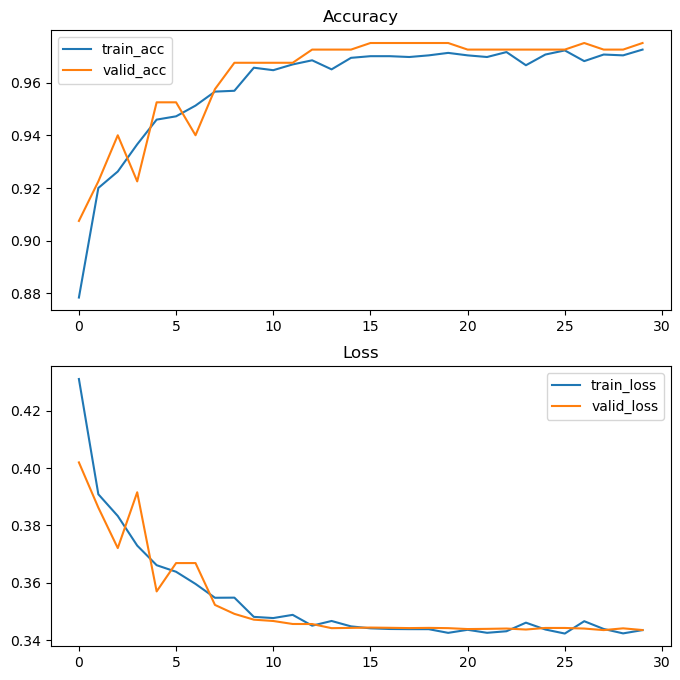

Accuracy: 96.75%
Recall: 96.75%
Precision: 96.81%
F1 Score: 96.75%


In [ ]:
# plot the accuracy and loss, then verify the model using test set
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
axs[0].plot(train_acc_lst, label='train_acc')
axs[0].plot(valid_acc_lst, label='valid_acc')
axs[0].set_title('Accuracy')
axs[0].legend()
axs[1].plot(train_loss_lst, label='train_loss')
axs[1].plot(valid_loss_lst, label='valid_loss')
axs[1].set_title('Loss')
axs[1].legend()
plt.show()
verify_model(best_model_CustomCNNWithAttention, test_loader)

#### with Adam optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_CustomCNNWithAttention_model_adam = torch.optim.Adam(
    CustomCNNWithAttention_model.parameters(), lr=1e-4
)
exp_lr_scheduler_CustomCNNWithAttention = lr_scheduler.StepLR(
    optimizer_CustomCNNWithAttention_model_adam, step_size=7, gamma=0.1
)
# train
(
    model_CustomCNNWithAttention,
    best_model_CustomCNNWithAttention,
    train_acc_lst,
    valid_acc_lst,
    train_loss_lst,
    valid_loss_lst,
) = train_model(
    CustomCNNWithAttention_model,
    criterion,
    optimizer_CustomCNNWithAttention_model_adam,
    exp_lr_scheduler_CustomCNNWithAttention,
    num_epochs=30,
)
# detatch the train_acc_lst, valid_acc_lst, train_loss_lst, valid_loss_lst
train_acc_lst = [i.detach().cpu().numpy() for i in train_acc_lst]
valid_acc_lst = [i.detach().cpu().numpy() for i in valid_acc_lst]

Epoch 0/29
train Loss: 0.8087 Acc: 0.5031
val Loss: 0.5400 Acc: 0.7675
Epoch 1/29
train Loss: 0.4366 Acc: 0.8750
val Loss: 0.4237 Acc: 0.8900
Epoch 2/29
train Loss: 0.3962 Acc: 0.9159
val Loss: 0.3941 Acc: 0.9175
Epoch 3/29
train Loss: 0.3847 Acc: 0.9266
val Loss: 0.3840 Acc: 0.9250
Epoch 4/29
train Loss: 0.3846 Acc: 0.9259
val Loss: 0.3840 Acc: 0.9200
Epoch 5/29
train Loss: 0.3681 Acc: 0.9447
val Loss: 0.3810 Acc: 0.9300
Epoch 6/29
train Loss: 0.3699 Acc: 0.9419
val Loss: 0.3531 Acc: 0.9600
Epoch 7/29
train Loss: 0.3598 Acc: 0.9525
val Loss: 0.3561 Acc: 0.9575
Epoch 8/29
train Loss: 0.3552 Acc: 0.9578
val Loss: 0.3517 Acc: 0.9625
Epoch 9/29
train Loss: 0.3567 Acc: 0.9563
val Loss: 0.3520 Acc: 0.9625
Epoch 10/29
train Loss: 0.3497 Acc: 0.9637
val Loss: 0.3460 Acc: 0.9675
Epoch 11/29
train Loss: 0.3475 Acc: 0.9641
val Loss: 0.3527 Acc: 0.9625
Epoch 12/29
train Loss: 0.3442 Acc: 0.9688
val Loss: 0.3520 Acc: 0.9650
Epoch 13/29
train Loss: 0.3461 Acc: 0.9666
val Loss: 0.3444 Acc: 0.9675
Ep

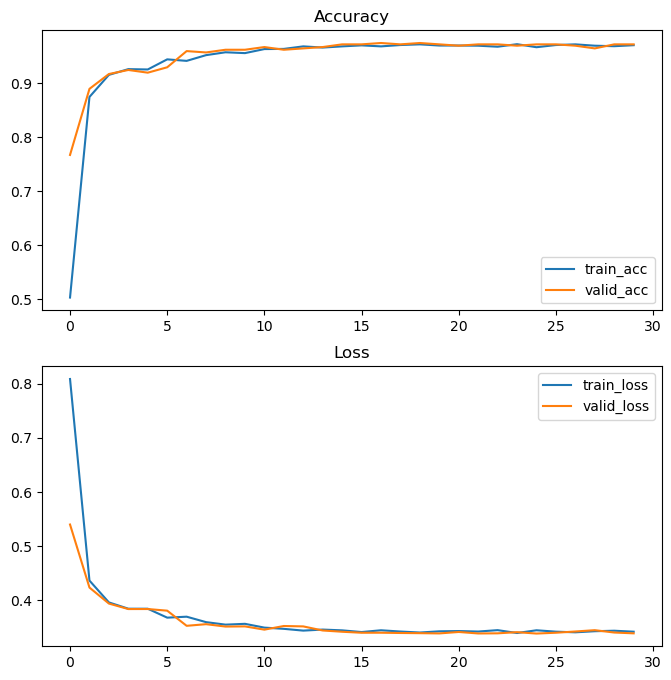

Accuracy: 96.75%
Recall: 96.75%
Precision: 96.89%
F1 Score: 96.75%


In [ ]:
# plot the accuracy and loss, then verify the model using test set
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
axs[0].plot(train_acc_lst, label='train_acc')
axs[0].plot(valid_acc_lst, label='valid_acc')
axs[0].set_title('Accuracy')
axs[0].legend()
axs[1].plot(train_loss_lst, label='train_loss')
axs[1].plot(valid_loss_lst, label='valid_loss')
axs[1].set_title('Loss')
axs[1].legend()
plt.show()
verify_model(best_model_CustomCNNWithAttention, test_loader)

## Compare the performance of the attention and non-attention models

Surprisingly, we found that the attention model's accuracy was lower than that of the non-attention model, with the former achieving 96% accuracy and the latter 97.5%. And we may explain this phenomenon from the following perspectives:

1. **Task simplicity:** The task of classifying images with and without packages on the ground may too simple, and the non-attention model (pure cnn) might already be capturing the necessary features to perform the classification effectively. Therefore, the addition of the self-attention mechanism might not provide any significant benefits and could even introduce additional noise or complexity to the model, thus reducing its performance.

2. **Model complexity:** The self-attention mechanism increases the model's complexity and number of parameters. This could lead to overfitting, especially with limit datasets in our experiment. The non-attention model with simpler structure might generalize better to the test data, resulting in higher accuracy.

## Compare the performance bwtween the SGD and Adam optimizer

We also observed that Adam slightly outperforms SGD in our experiments, and the accuracy of the model with Adam optimizer increases smoothly with the number of epochs, while SGD exhibits larger fluctuations. The reasons for these differences may be attributed to the following factors:

1. Adaptive learning rates: Adam uses adaptive learning rates for each parameter, whereas SGD uses a constant learning rate for all parameters. This adaptivity allows Adam to make more informed updates based on the individual gradient magnitudes, which can lead to smoother convergence and less fluctuation in the accuracy.

2. Momentum and second-moment estimation: Adam incorporates momentum and second-moment estimation in its update rule, which helps the optimizer to dampen oscillations and make more stable progress in the parameter space. This characteristic can result in a smoother increase in accuracy across epochs when compared to SGD.

## Summary

### Performance comparison
| Model                                  | Accuracy | Recall | Precision | F1 Score |
| -------------------------------------- | -------- | ------ | --------- | -------- |
| Pretrained Resnet18                    | 99.00%   | 99.00% | 99.02%    | 99.00%   |
| Custom Model (pure CNN)                | 96.75%   | 96.75% | 96.76%    | 96.75%   |
| Custom Model (pure CNN with attention) | 96.75%   | 96.75% | 96.89%    | 96.75%   |

In this report, we tried different approach to develop a robust and efficient image classification model for the given dataset. We preprocess the data and address the class imbalance issue by augmenting the minority class, which consists of empty images (460) as opposed to occupied images (2,000). This step ensures that the model is trained on a more balanced dataset, reducing potential biases in its predictions.

We experiment with three different models to perform the classification task: a pre-trained ResNet18 with a modified last fully connected layer, a custom CNN model, and a custom CNN model with an attention mechanism. Our results demonstrate that the pre-trained ResNet18 achieves the highest accuracy, while the CNN model outperforms the CNN model with attention. We speculate that the relatively small dataset size may contribute to the inferior performance of the attention-based model.

In our experiments, we also explore different hyperparameters, such as the optimizer (SGD and Adam) and learning rate schedulers, to fine-tune the models' performance. We observe that varying these parameters can significantly impact the training dynamics and final model accuracy.

Based on our findings, we conclude that transfer learning from a pre-trained model, such as ResNet18, is the most cost-effective approach for this classification task, particularly when dealing with limited datasets. Employing a pre-trained model allows us to leverage the existing knowledge encoded in its weights, leading to faster convergence and better generalization compared to training a custom model from scratch. As such, we recommend the use of transfer learning in similar real-life applications where dataset size is limited and computational resources are constrained.